# Speckle Size Analysis

In [1]:
import speckle
from speckle.inference.read_in_data import read_in_data
from speckle.inference.correlation_heatmap import get_correlation,dump_heatmap,display_correlation_heatmaps,mask_heatmap,plot_radius_distribution
from speckle.inference.calculating_tau import objective, avg_correlation_single_px, plot_correlation_vs_lagtime,fit_exponential_decay, reconstruct,avg_correlation,calculate_correlation_pixel
from speckle.inference.dedrift import dedrift_videos

In [2]:
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import numpy as np
from scipy.optimize import curve_fit
import math
from operator import itemgetter

In [3]:
def spatial_correlation(example_img, sp_shape,ROI):
    y_length=example_img.shape[0]
    x_length=example_img.shape[1]
    num_pixels=y_length*x_length
    spcorrelation_map = np.zeros((sp_shape,sp_shape))
    for dy in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
        for dx in range(-math.floor(sp_shape/2), math.floor(sp_shape/2), 1):
            sum_numerator=0
            sum_denum_1=0
            sum_denum_2=0
            count=0
            for y in range(ROI[0],ROI[0]+ROI[2],1):
                for x in range(ROI[1],ROI[1]+ROI[3],1):
                    sum_numerator+=int(example_img[y][x])*int(example_img[y+dy][x+dx])
                    sum_denum_1+=int(example_img[y][x])
                    sum_denum_2+=int(example_img[y+dy][x+dx])
                    count+=1
            numerator=sum_numerator/count
            denum_1=sum_denum_1/count
            denum_2=sum_denum_2/count
            spcorrelation_map[dy+math.floor(sp_shape/2)][dx+math.floor(sp_shape/2)]=copy.deepcopy(numerator/(denum_1*denum_2)-1)
    normalization=spcorrelation_map[math.floor(sp_shape/2)][math.floor(sp_shape/2)]
    spcorrelation_map=spcorrelation_map/normalization
    sns.heatmap(spcorrelation_map)
    return spcorrelation_map

In [4]:
def plot_spmap(spcorrelation_map):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.')
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [5]:
def plot_spmap_x_direction(spcorrelation_map):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    
    plt.plot(radius_squared,spcorrelation_map_x,'.')
    #plt.xlim(0,10)
    plt.legend(['Correlation vs delta r'], fontsize=18)
    plt.xlabel("delta r [pixels]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.show

In [6]:
def calculate_speckle_size(spcorrelation_map,startidx,endidx,plotBoolean=True):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.array(np.concatenate(radius).flat)
    spcorrelation_map_flatten=np.array(np.concatenate(spcorrelation_map).flat)
    radius_squared=radius_flatten*radius_flatten
    log_correlation=np.log(abs(spcorrelation_map_flatten))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        return np.sqrt(-1/a)

def objective(x, a):
	return a * x

In [7]:
def calculate_speckle_size_x_direction(spcorrelation_map,startidx,endidx,plotBoolean=True):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=spcorrelation_map[int(spcorrelation_map.shape[0]/2)][:]
    log_correlation=np.log(abs(spcorrelation_map_x))
    combined_list=[]
    combined_list.append(radius_squared)
    combined_list.append(log_correlation)
    combined_list=np.array(combined_list)
    combined_list_sorted=np.array(sorted(combined_list.transpose(),key=lambda lst:lst[1],reverse=True)).transpose()
    if plotBoolean==True:
        x, y = combined_list_sorted[0][startidx:endidx], combined_list_sorted[1][startidx:endidx]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        print("speckle size is:",np.sqrt(-1/a))
        print('y = %.5f * x' % (a))
        # plot input vs output
        plt.scatter(x, y)
        
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 1)
        # calculate the output for the range
        y_line = objective(x_line, a)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')
        plt.show()
        return np.sqrt(-1/a),a
    else:
        x, y = combined_list_sorted[0][0:20], combined_list_sorted[1][0:20]
        # curve fit
        popt, _ = curve_fit(objective, x, y)
        # summarize the parameter values
        a= popt
        return np.sqrt(-1/a)

def objective(x, a):
	return a * x

In [8]:
def reconstruct_curve(spcorrelation_map,a):
    xv, yv = np.meshgrid(np.arange(-math.floor(spcorrelation_map.shape[0]/2),math.floor(spcorrelation_map.shape[0]/2),1),np.arange(-math.floor(spcorrelation_map.shape[1]/2),math.floor(spcorrelation_map.shape[1]/2),1))
    radius = np.sqrt(xv**2 + yv**2)
    radius_flatten=np.concatenate(radius).flat
    spcorrelation_map_flatten=np.concatenate(spcorrelation_map).flat
    y=np.zeros(len(radius_flatten))
    for i in range(0, len(radius_flatten),1):
        y[i]=(math.exp(a*radius_flatten[i]))
    plt.figure(figsize=(8,5))
    plt.plot(radius_flatten,y,'*',label="fit line")
    plt.plot(radius_flatten,spcorrelation_map_flatten,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

In [9]:
def reconstruct_curve_x_direction(spcorrelation_map,a):
    x_radius=np.arange(-spcorrelation_map.shape[0]/2,spcorrelation_map.shape[0]/2,1)
    radius_squared=x_radius**2
    spcorrelation_map_x=np.array(spcorrelation_map)[int(spcorrelation_map.shape[0]/2)][:]
    
    y=np.zeros(len(radius_squared))
    for i in range(0, len(radius_squared),1):
        y[i]=(math.exp(a*radius_squared[i]))
    plt.figure(figsize=(8,5))
    plt.plot(radius_squared,y,'*',label="fit line")
    plt.plot(radius_squared,spcorrelation_map_x,'.',label="data")
    plt.legend(['Correlation vs Delta r'], fontsize=18)
    plt.xlabel("Delta r [pixel]",fontsize=18)
    plt.ylabel("Correlation",fontsize=18)
    plt.legend(fontsize=18)

# 24 hour video (256*256 size) - FUS

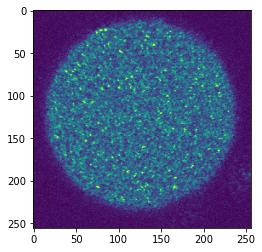

In [10]:
## Load in data
video_time_length=60 #s
video_frame_numbers=1129 #frames
imgname='1120f_FUS_24h_condensate_speckle_BF_1min_#2_equator'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/FUS_24h_condensate_speckle_BF_1min_#2_equator/'
framespeed=video_time_length/video_frame_numbers
img=read_in_data(foldername,imgname)

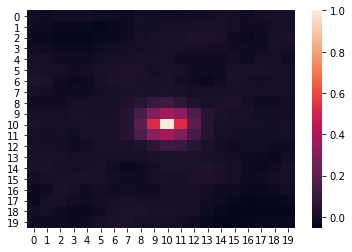

In [11]:
img_24h=img[20]
ROI=[80,70,100,110] #y,x,w,h
sp_shape=20
spmap_24h=spatial_correlation(img_24h,sp_shape,ROI)

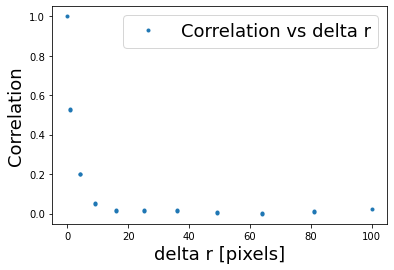

In [12]:
plot_spmap_x_direction(spmap_24h)

corresponds to speckle size $c_I(\delta_{r}) = exp(-\delta_{r}^2/\sigma^2)$

speckle size is: [1.5478303]
y = -0.41740 * x


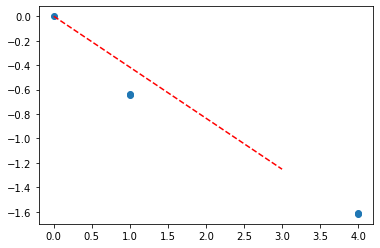

In [13]:
size_24h,a_24h =calculate_speckle_size_x_direction(spmap_24h,0,5)

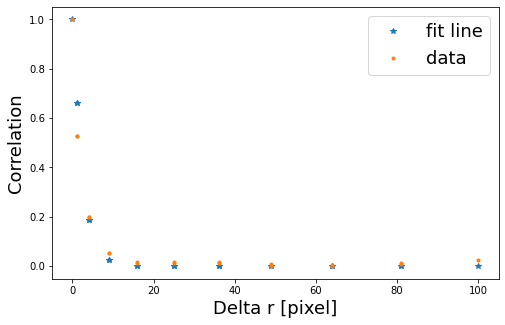

In [27]:
a_24h=-0.417
reconstruct_curve_x_direction(spmap_24h,a_24h)

In [47]:
scale=9.775
speckle_size_24h=np.sqrt(-1/a_24h)/scale
print('The size is :'+str(np.sqrt(-1/a_24h))+' pixel')
print('The size is :'+str(speckle_size_24h)+' um')

The size is :1.5485740327062774 pixel
The size is :0.15842189592903091 um


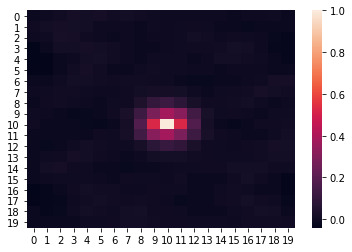

In [29]:
img_24h_900=img[900]
ROI=[80,70,100,110] #y,x,w,h
sp_shape=20
spmap_24h_900=spatial_correlation(img_24h_900,sp_shape,ROI)

In [ ]:
plot_spmap(spmap_24h_900)

In [ ]:
size_24h_900,a_24h_900=calculate_speckle_size(spmap_24h_900,0,6)

In [ ]:
a_24h_900=-0.95
reconstruct_curve(spmap_24h_900,a_24h_900)

In [ ]:
scale=9.775
speckle_size_24h_900=np.sqrt(-1/a_24h_900)/scale
print('The size is :'+str(np.sqrt(-1/a_24h_900))+' pixel')
print('The size is :'+str(speckle_size_24h_900)+' um')

# Fresh video(512*512) -FUS

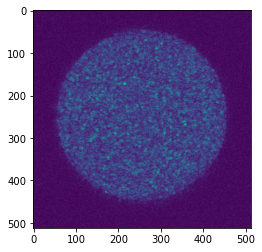

In [30]:
imgname='300f_405_1.0p_725gain_2min_1141frames_fresh'
foldername='/Users/wenyun/Desktop/research/Speckle project/Temp_data/405_1.0p_725gain_2min_1141frames_fresh/'
img=read_in_data(foldername,imgname)

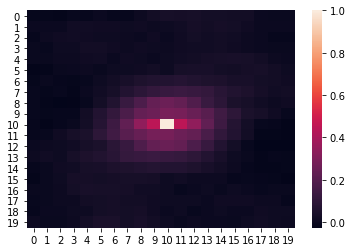

In [32]:
img_fresh_20=img[20]
ROI=[200,200,100,100] #y,x,w,h
sp_shape=20
spmap_fresh_20=spatial_correlation(img_fresh_20,sp_shape,ROI)

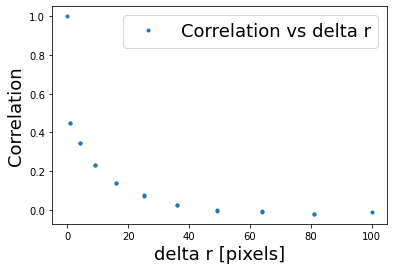

In [33]:
plot_spmap_x_direction(spmap_fresh_20)

speckle size is: [3.79666124]
y = -0.06937 * x


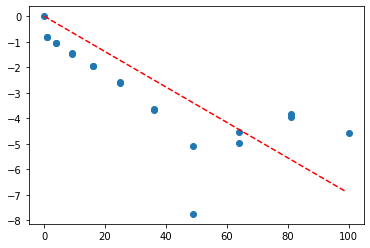

In [59]:
size_fresh,a_fresh=calculate_speckle_size_x_direction(spmap_fresh_20,0,20)

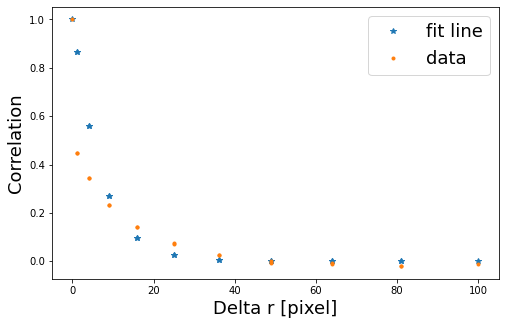

In [78]:
a_fresh=-0.145
reconstruct_curve_x_direction(spmap_fresh_20,a_fresh)

In [79]:
scale= 20.5155
speckle_size_fresh=np.sqrt(-1/a_fresh)/scale
print('The size is :'+str(np.sqrt(-1/a_fresh))+' pixel')
print('The size is :'+str(speckle_size_fresh)+' um')

The size is :2.6261286571944513 pixel
The size is :0.12800705111717733 um


bidirectional scan not aligned well

# UVed

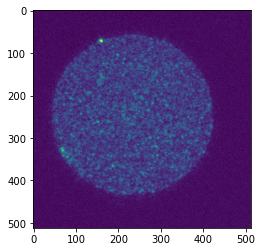

In [63]:
imgname='405_1.0p_725gain_2min_1141frmaes_fresh_after_UV'
foldername='/Users/wenyun/Desktop/research/Speckle project/Temp_data/405_1.0p_725gain_2min_1141frmaes_fresh_after_UV/'
img=read_in_data(foldername,imgname)

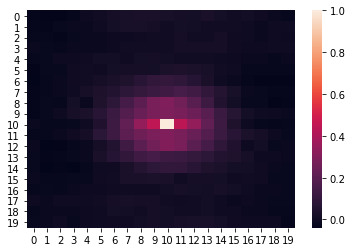

In [64]:
img_UV_20=img[20]
ROI=[200,200,100,100] #y,x,w,h
sp_shape=20
spmap_UV_20=spatial_correlation(img_UV_20,sp_shape,ROI)

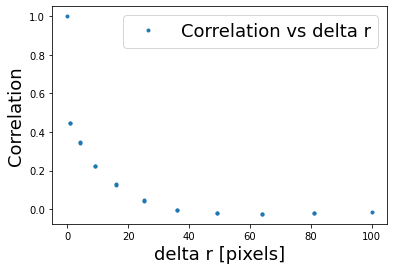

In [65]:
plot_spmap_x_direction(spmap_UV_20)

speckle size is: [2.20762985]
y = -0.20519 * x


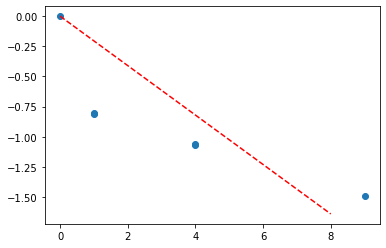

In [68]:
size_UVed,a_UVed=calculate_speckle_size_x_direction(spmap_UV_20,0,6)

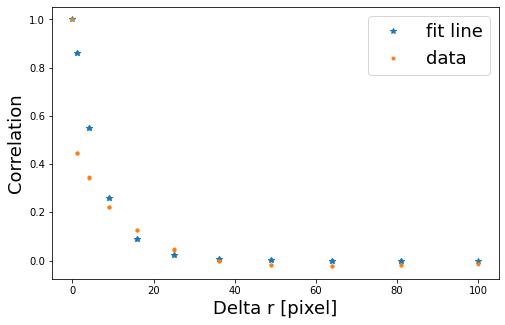

In [81]:
a_UVed=-0.15
reconstruct_curve_x_direction(spmap_UV_20,a_UVed)

In [82]:
scale= 20.5155
speckle_size_UVed=np.sqrt(-1/a_UVed)/scale
print('The size is :'+str(np.sqrt(-1/a_UVed))+' pixel')
print('The size is :'+str(speckle_size_UVed)+' um')

The size is :2.581988897471611 pixel
The size is :0.12585551887458807 um


# G3BP1

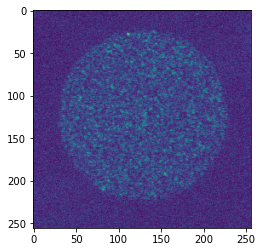

In [83]:
imgname='speckle_GFP_G3BP1_405nm_9power_2haged_equator_30s'
foldername='/Volumes/wwyyrx/Wenyun/Speckle/speckle_GFP_G3BP1_405nm_9power_2haged_equator_30s/'
img=read_in_data(foldername,imgname)

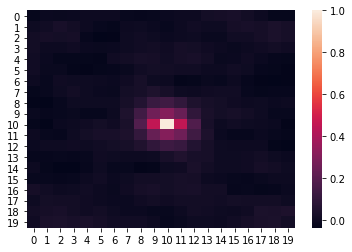

In [84]:
img_G3BP1_20=img[20]
ROI=[100,80,80,80] #y,x,w,h
sp_shape=20
spmap_G3BP1_20=spatial_correlation(img_G3BP1_20,sp_shape,ROI)

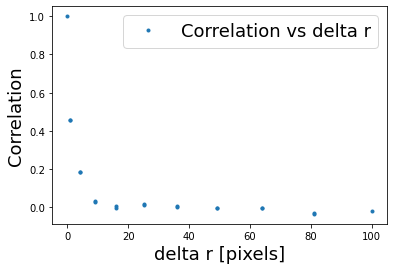

In [85]:
plot_spmap_x_direction(spmap_G3BP1_20)

speckle size is: [1.49902882]
y = -0.44502 * x


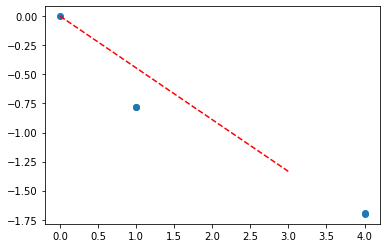

In [87]:
size_G3BP1,a_G3BP1=calculate_speckle_size_x_direction(spmap_G3BP1_20,0,5)

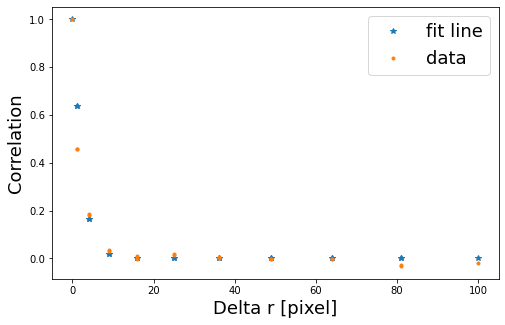

In [89]:
a_G3BP1=-0.45
reconstruct_curve_x_direction(spmap_G3BP1_20,a_G3BP1)

In [90]:
scale= 10.255
speckle_size_G3BP1=np.sqrt(-1/a_G3BP1)/scale
print('The size is :'+str(np.sqrt(-1/a_G3BP1))+' pixel')
print('The size is :'+str(speckle_size_G3BP1)+' um')

The size is :1.4907119849998598 pixel
The size is :0.14536440614333102 um


# PS beads (256*256)

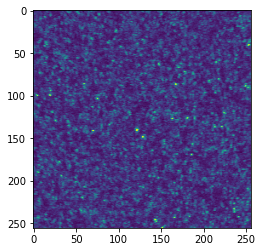

In [94]:
imgname='0p5wt_100nm_256px_1min_10to1_waterglycerol_1au'
foldername='/Volumes/WENYUN WANG/20220606/'
img=read_in_data(foldername,imgname)

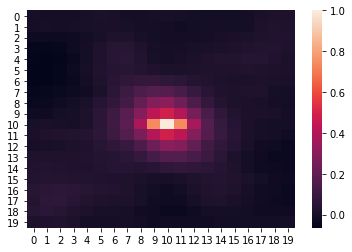

In [95]:
img_PS_20=img[20]
ROI=[100,80,80,80] #y,x,w,h
sp_shape=20
spmap_PS_20=spatial_correlation(img_PS_20,sp_shape,ROI)

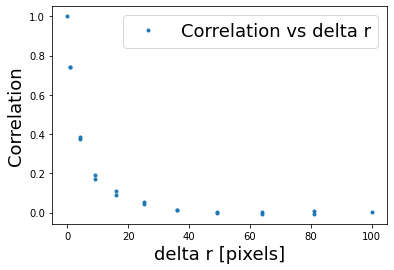

In [96]:
plot_spmap_x_direction(spmap_PS_20)

speckle size is: [3.49208209]
y = -0.08200 * x


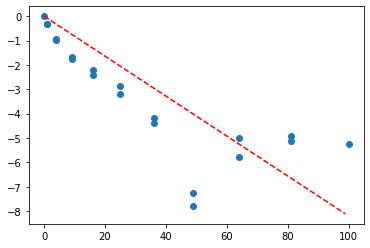

In [97]:
size_PS,a_PS=calculate_speckle_size_x_direction(spmap_PS_20,0,20)

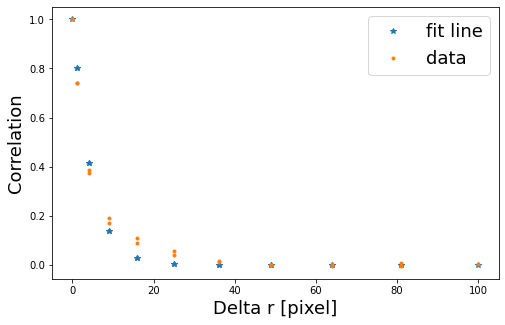

In [107]:
a_PS=-0.22
reconstruct_curve_x_direction(spmap_PS_20,a_PS)

In [105]:
scale= 10.8611
speckle_size_PS=np.sqrt(-1/a_PS)/scale
print('The size is :'+str(np.sqrt(-1/a_PS))+' pixel')
print('The size is :'+str(speckle_size_PS)+' um')

The size is :2.1320071635561044 pixel
The size is :0.19629753556786186 um


# PS beads (512*512 px)

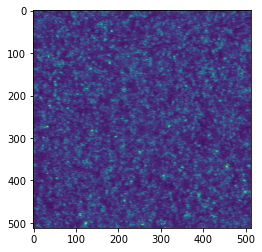

In [108]:
imgname='0p5wt_100nm_512px_1min_10to1_waterglycerol_1au'
foldername='/Volumes/WENYUN WANG/20220606/'
img=read_in_data(foldername,imgname)

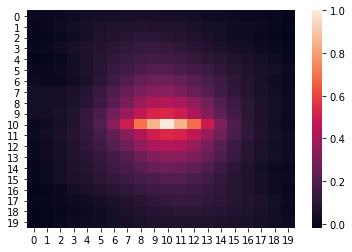

In [109]:
img_PS_512px=img[300]
ROI=[50,80,120,120] #y,x,w,h
sp_shape=20
spmap_PS_512px=spatial_correlation(img_PS_512px,sp_shape,ROI)

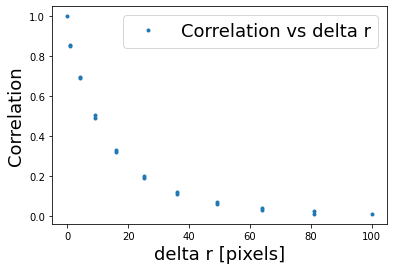

In [110]:
plot_spmap_x_direction(spmap_PS_512px)

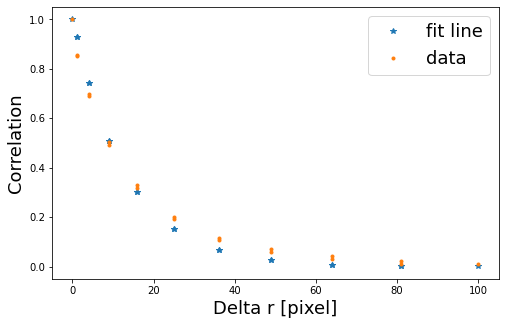

In [127]:
a_PS_512px=-0.075
reconstruct_curve_x_direction(spmap_PS_512px,a_PS_512px)

In [128]:
scale= 21.7233
speckle_size_PS_512px=np.sqrt(-1/a_PS_512px)/scale
print('The size is :'+str(np.sqrt(-1/a_PS_512px))+' pixel')
print('The size is :'+str(speckle_size_PS_512px)+' um')

The size is :3.6514837167011076 pixel
The size is :0.16809065458291825 um


# 1wt glycerol 100nm 20objective 0614 20x_magnification

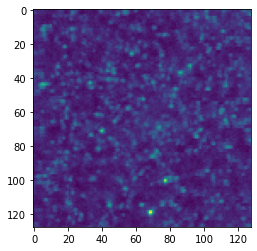

In [129]:
imgname='28p_1wt_100nm128px_2min_glycerol_1au_20x_26p5umhigh_488nm_20xobjective'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/28p_1wt_100nm128px_2min_glycerol_1au_20x_26p5umhigh_488nm_20xobjective/'
img=read_in_data(foldername,imgname)

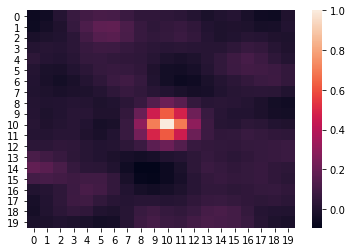

In [131]:
img_gly_100nm=img[300]
ROI=[40,40,40,40] #y,x,w,h
sp_shape=20
spmap_gly_100nm=spatial_correlation(img_gly_100nm,sp_shape,ROI)

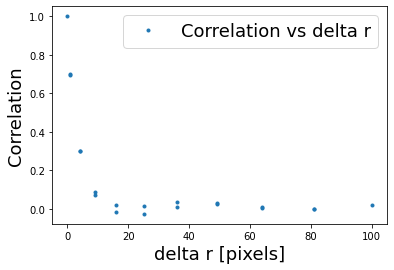

In [167]:
plot_spmap_x_direction(spmap_gly_100nm)

speckle size is: [1.8098437]
y = -0.30529 * x


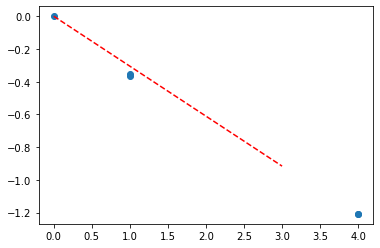

In [168]:
size_gly_100nm,a_gly_100nm=calculate_speckle_size_x_direction(spmap_gly_100nm,0,5)

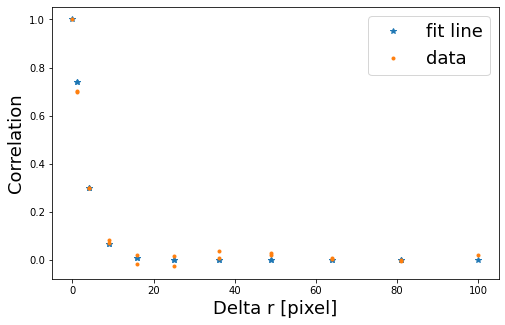

In [170]:
a_gly_100nm=-0.3
reconstruct_curve_x_direction(spmap_gly_100nm,a_gly_100nm)

In [171]:
scale= 6.0340
speckle_size_gly_100nm=np.sqrt(-1/a_gly_100nm)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm)+' um')

The size is :1.8257418583505538 pixel
The size is :0.3025757140123556 um


# 1wt glycerol 100nm 20objective 0614 30x_magnification

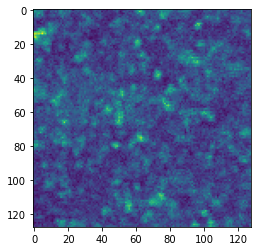

In [11]:
imgname='12p_1wt_100nm128px_2min_glycerol_1au_30x_58p5umhigh_488nm_20xobjective'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/12p_1wt_100nm128px_2min_glycerol_1au_30x_58p5umhigh_488nm_20xobjective/'
img=read_in_data(foldername,imgname)

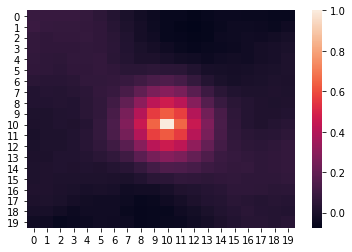

In [14]:
img_gly_100nm_30x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_30x=spatial_correlation(img_gly_100nm_30x,sp_shape,ROI)

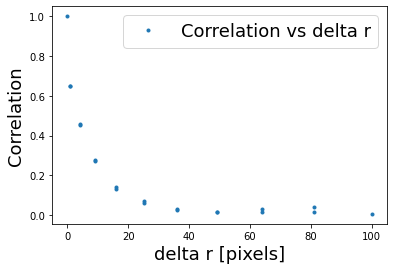

In [15]:
plot_spmap_x_direction(spmap_gly_100nm_30x)

speckle size is: [2.1824644]
y = -0.20995 * x


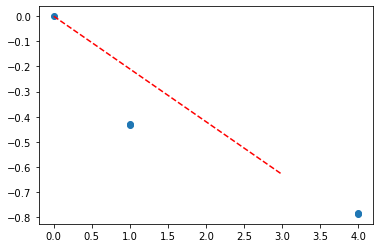

In [17]:
size_gly_100nm_30x,a_gly_100nm_30x=calculate_speckle_size_x_direction(spmap_gly_100nm_30x,0,5)

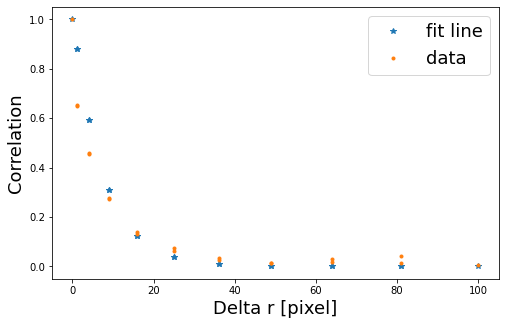

In [22]:
a_gly_100nm_30x=-0.13
reconstruct_curve_x_direction(spmap_gly_100nm_30x,a_gly_100nm_30x)

In [24]:
scale= 9.0509
speckle_size_gly_100nm_30x=np.sqrt(-1/a_gly_100nm_30x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_30x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_30x)+' um')

The size is :2.7735009811261455 pixel
The size is :0.30643372273764435 um


# 40p_1wt_50nm128px_2min_glycerol_1au_20x_7umhigh_488nm (40x water obj. 1.2NA)

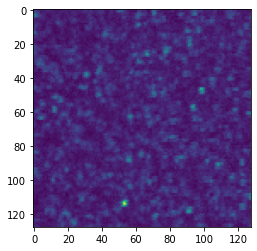

In [41]:
imgname='40p_1wt_50nm128px_2min_glycerol_1au_20x_7umhigh_405nm'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/40p_1wt_50nm128px_2min_glycerol_1au_20x_7umhigh_405nm/'
img=read_in_data(foldername,imgname)

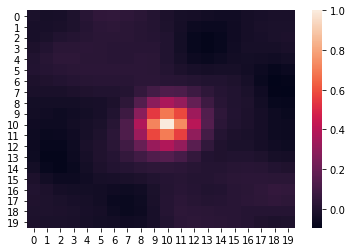

In [42]:
img_gly_50nm_40xobj=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_50nm_40xobj=spatial_correlation(img_gly_50nm_40xobj,sp_shape,ROI)

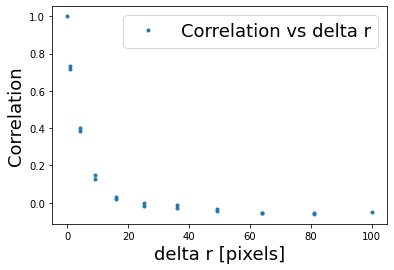

In [43]:
plot_spmap_x_direction(spmap_gly_50nm_40xobj)

speckle size is: [2.04714207]
y = -0.23862 * x


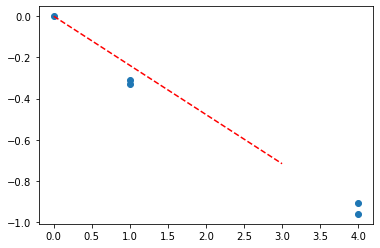

In [44]:
size_gly_50nm_40xobj,a_gly_50nm_40xobj=calculate_speckle_size_x_direction(spmap_gly_50nm_40xobj,0,5)

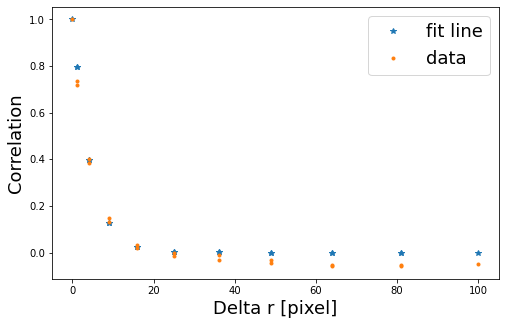

In [53]:
a_gly_50nm_40xobj=-0.23
reconstruct_curve_x_direction(spmap_gly_50nm_40xobj,a_gly_50nm_40xobj)

In [54]:
scale= 12.0679
speckle_size_gly_50nm_40xobj=np.sqrt(-1/a_gly_50nm_40xobj)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_50nm_40xobj))+' pixel')
print('The size is :'+str(speckle_size_gly_50nm_40xobj)+' um')

The size is :2.0851441405707476 pixel
The size is :0.1727843403219075 um


# 60p_405nm_2min_1wt_50nm_20xobj_30xmagn_111p1umhigh

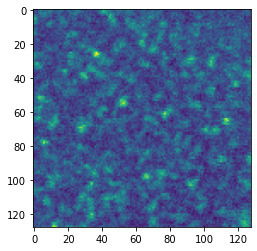

In [38]:
imgname='60p_405nm_2min_1wt_50nm_20xobj_30xmagn_111p1umhigh'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/60p_405nm_2min_1wt_50nm_20xobj_30xmagn_111p1umhigh/'
img=read_in_data(foldername,imgname)

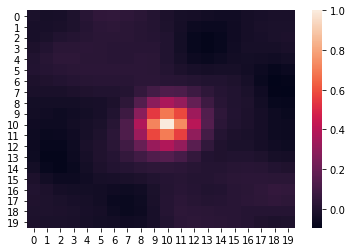

In [70]:
img_gly_50nm_20xobj_30x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_50nm_20xobj_30x=spatial_correlation(img_gly_50nm_20xobj_30x,sp_shape,ROI)

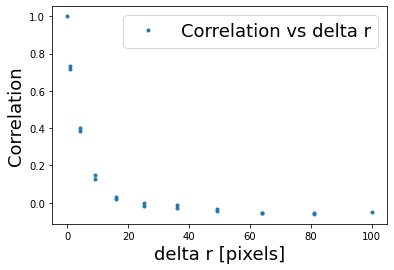

In [71]:
plot_spmap_x_direction(spmap_gly_50nm_20xobj_30x)

speckle size is: [2.04714207]
y = -0.23862 * x


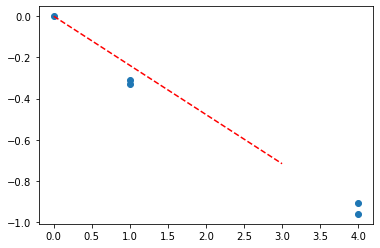

In [72]:
size_gly_50nm_20xobj_30x,a_gly_50nm_20xobj_30x=calculate_speckle_size_x_direction(spmap_gly_50nm_20xobj_30x,0,5)

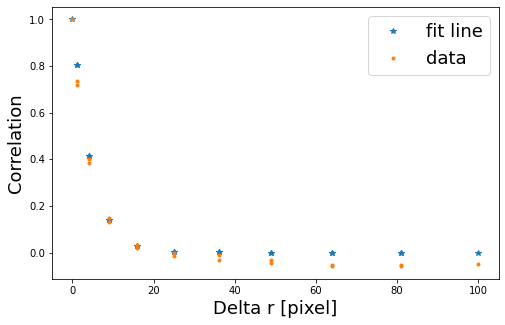

In [76]:
a_gly_50nm_20xobj_30x=-0.22
reconstruct_curve_x_direction(spmap_gly_50nm_20xobj_30x,a_gly_50nm_20xobj_30x)

In [74]:
scale= 9.0509
speckle_size_gly_50nm_20xobj_30x=np.sqrt(-1/a_gly_50nm_20xobj_30x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_50nm_20xobj_30x))+' pixel')
print('The size is :'+str(speckle_size_gly_50nm_20xobj_30x)+' um')

The size is :2.041241452319315 pixel
The size is :0.22552911338312379 um


# 40p_405nm_2min_1wt_100nm_10xobj_20xmagn_155p91umhigh

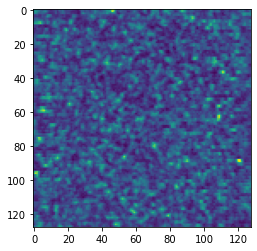

In [10]:
imgname='40p_405nm_2min_1wt_100nm_10xobj_20xmagn_155p91umhigh'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/40p_405nm_2min_1wt_100nm_10xobj_20xmagn_155p91umhigh/'
img=read_in_data(foldername,imgname)

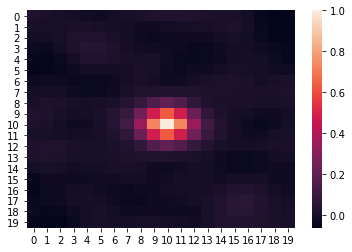

In [14]:
img_gly_100nm_10xobj_20x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_10xobj_20x=spatial_correlation(img_gly_100nm_10xobj_20x,sp_shape,ROI)

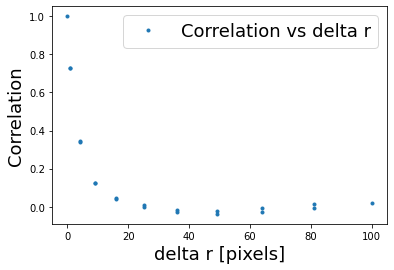

In [15]:
plot_spmap_x_direction(spmap_gly_100nm_10xobj_20x)

speckle size is: [1.92207512]
y = -0.27068 * x


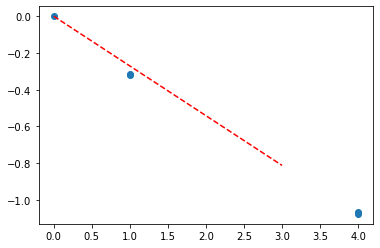

In [16]:
size_gly_100nm_10xobj_20x,a_gly_100nm_10xobj_20x=calculate_speckle_size_x_direction(spmap_gly_100nm_10xobj_20x,0,5)

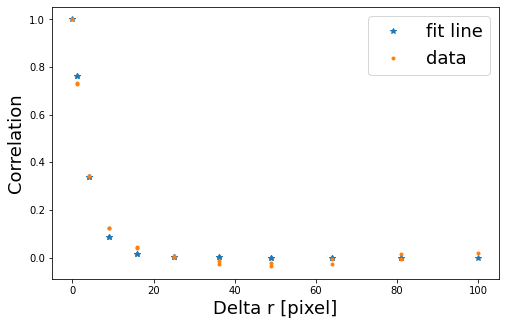

In [18]:
a_gly_100nm_10xobj_20x=-0.2708
reconstruct_curve_x_direction(spmap_gly_100nm_10xobj_20x,a_gly_100nm_10xobj_20x)

In [20]:
scale= 3.0170
speckle_size_gly_100nm_10xobj_20x=np.sqrt(-1/a_gly_100nm_10xobj_20x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_10xobj_20x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_10xobj_20x)+' um')

The size is :1.9216561050602199 pixel
The size is :0.6369426930925489 um


# 40p_405nm_2min_1wt_100nm_10xobj_40xmagn_155p91umhigh

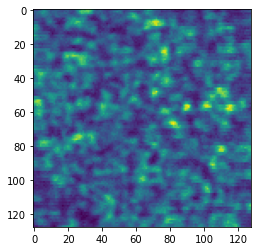

In [22]:
imgname='40p_405nm_2min_1wt_100nm_10xobj_40xmagn_155p91umhigh'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/40p_405nm_2min_1wt_100nm_10xobj_40xmagn_155p91umhigh/'
img=read_in_data(foldername,imgname)

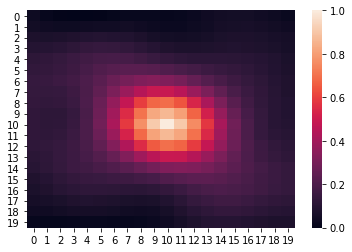

In [23]:
img_gly_100nm_10xobj_40x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_10xobj_40x=spatial_correlation(img_gly_100nm_10xobj_40x,sp_shape,ROI)

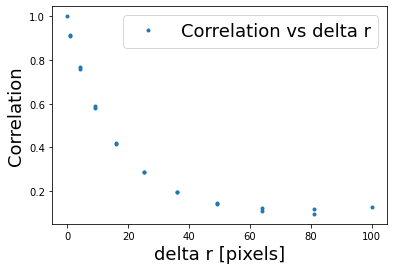

In [24]:
plot_spmap_x_direction(spmap_gly_100nm_10xobj_40x)

speckle size is: [4.32901062]
y = -0.05336 * x


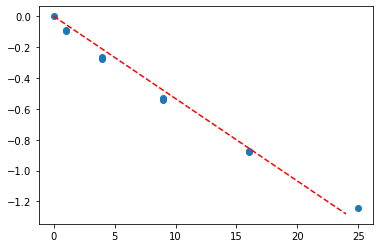

In [27]:
size_gly_100nm_10xobj_40x,a_gly_100nm_10xobj_40x=calculate_speckle_size_x_direction(spmap_gly_100nm_10xobj_40x,0,10)

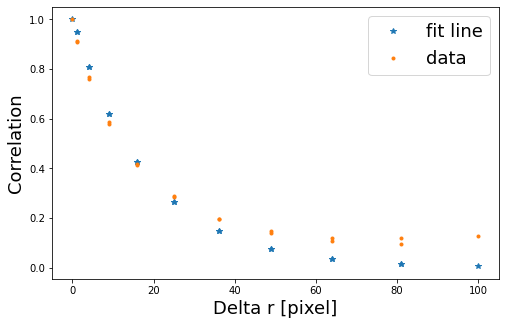

In [39]:
a_gly_100nm_10xobj_40x=-0.05336
reconstruct_curve_x_direction(spmap_gly_100nm_10xobj_40x,a_gly_100nm_10xobj_40x)

In [40]:
scale= 6.0340
speckle_size_gly_100nm_10xobj_40x=np.sqrt(-1/a_gly_100nm_10xobj_40x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_10xobj_40x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_10xobj_40x)+' um')

The size is :4.329044892947799 pixel
The size is :0.7174419776181304 um


# 28p_1wt_100nm128px_2min_glycerol_1au_20x_9umhigh_405nm

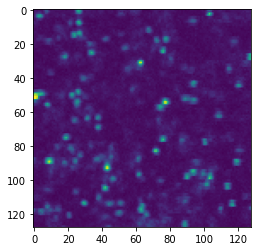

In [41]:
imgname='28p_1wt_100nm128px_2min_glycerol_1au_20x_9umhigh_405nm'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/28p_1wt_100nm128px_2min_glycerol_1au_20x_9umhigh_405nm/'
img=read_in_data(foldername,imgname)

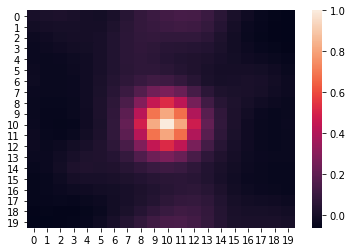

In [42]:
img_gly_100nm_40xobj_20x=img[300]
ROI=[20,20,80,80] #y,x,w,h
sp_shape=20
spmap_gly_100nm_40xobj_20x=spatial_correlation(img_gly_100nm_40xobj_20x,sp_shape,ROI)

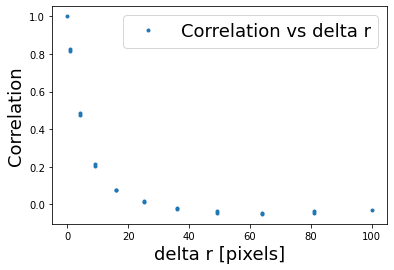

In [43]:
plot_spmap_x_direction(spmap_gly_100nm_40xobj_20x)

speckle size is: [2.33168583]
y = -0.18393 * x


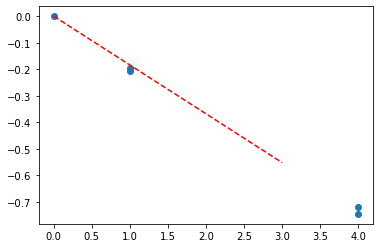

In [45]:
size_gly_100nm_40xobj_20x,a_gly_100nm_40xobj_20x=calculate_speckle_size_x_direction(spmap_gly_100nm_40xobj_20x,0,5)

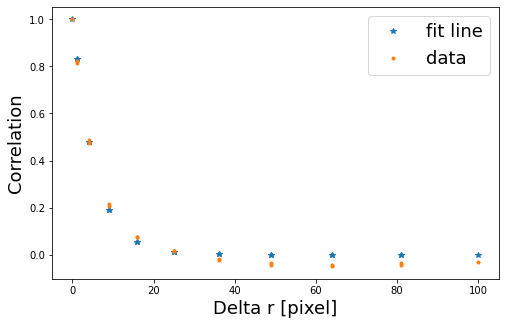

In [46]:
a_gly_100nm_40xobj_20x=-0.18393
reconstruct_curve_x_direction(spmap_gly_100nm_40xobj_20x,a_gly_100nm_40xobj_20x)

In [47]:
scale= 12.0679
speckle_size_gly_100nm_40xobj_20x=np.sqrt(-1/a_gly_100nm_40xobj_20x)/scale
print('The size is :'+str(np.sqrt(-1/a_gly_100nm_40xobj_20x))+' pixel')
print('The size is :'+str(speckle_size_gly_100nm_40xobj_20x)+' um')

The size is :2.3317055937477935 pixel
The size is :0.1932155216523002 um
